In [24]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"


import numpy as np
import os

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

import util as utl

np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "svm"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def print_scores(model, X, y, w='weighted'):
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    print('Accuracy: ', acc)
    print('Precision: ', precision_score(y, y_pred, average=w))
    print('Recall: ', recall_score(y, y_pred, average=w))
    print('F1: ', f1_score(y, y_pred, average=w))

In [26]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)

X = mnist["data"]
y = mnist["target"].astype(np.uint8)

X_train = X[:60000]
y_train = y[:60000]
X_test = X[60000:]
y_test = y[60000:]

In [27]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float32))
X_test_scaled = scaler.transform(X_test.astype(np.float32))

In [73]:
from sklearn.svm import SVC

svc_poly = SVC(kernel='poly')

In [82]:
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    "coef0": [0.01, 0.018, 0.02, 0.024, 0.03, 0.001, 0.003],
    "C": [0.1, 0.3, 0.5, 1, 5, 10],
    "degree": [1, 3, 5, 6],
}

rnd_search_poly= RandomizedSearchCV(svc_poly, param_distributions, scoring="accuracy", n_iter=5, verbose=2, cv=10, random_state=42)
rnd_search_poly.fit(X_train_scaled[:5000], y_train[:5000])

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] END .........................C=5, coef0=0.003, degree=3; total time=   2.4s
[CV] END .........................C=5, coef0=0.003, degree=3; total time=   2.2s
[CV] END .........................C=5, coef0=0.003, degree=3; total time=   2.1s
[CV] END .........................C=5, coef0=0.003, degree=3; total time=   2.3s
[CV] END .........................C=5, coef0=0.003, degree=3; total time=   2.2s
[CV] END .........................C=5, coef0=0.003, degree=3; total time=   2.3s
[CV] END .........................C=5, coef0=0.003, degree=3; total time=   2.3s
[CV] END .........................C=5, coef0=0.003, degree=3; total time=   2.4s
[CV] END .........................C=5, coef0=0.003, degree=3; total time=   2.5s
[CV] END .........................C=5, coef0=0.003, degree=3; total time=   2.5s
[CV] END ........................C=0.3, coef0=0.01, degree=5; total time=   4.7s
[CV] END ........................C=0.3, coef0=0.

,estimator,SVC(kernel='poly')
,param_distributions,"{'C': [0.1, 0.3, ...], 'coef0': [0.01, 0.018, ...], 'degree': [1, 3, ...]}"
,n_iter,5
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,10
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [83]:
rnd_search_poly.best_params_

{'degree': 3, 'coef0': 0.003, 'C': 5}

In [84]:
rnd_search_poly.best_estimator_.fit(X_train_scaled, y_train)

,C,5
,kernel,'poly'
,degree,3
,gamma,'scale'
,coef0,0.003
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [85]:
# test_clf = SVC(kernel='poly', C=5, coef0=0.003, degree=1)

# test_clf.fit(X_train_scaled[:4000], y_train[:4000])

In [86]:
from sklearn.model_selection import ShuffleSplit, LearningCurveDisplay

def draw_learning_curve(model, X, y, title):
    common_params = {
        "X": X,
        "y": y,
        "train_sizes": np.linspace(0.1, 1.0, 5),
        "cv": ShuffleSplit(n_splits=10, test_size=0.2, random_state=42),
        "score_type": "both",
        "scoring": "accuracy",
        "line_kw": {"marker": "o"},
        "std_display_style": 'fill_between',
    }
    fig, ax = plt.subplots(figsize=(8, 5))
    plt.subplots_adjust(hspace=0.5)

    LearningCurveDisplay.from_estimator(model, **common_params, ax=ax)
    handles, label = ax.get_legend_handles_labels()
    ax.legend(handles[:2], ["Train Score", "Test Score"])
    ax.set_title(title)
    ax.set_xlabel("Set size")
    ax.grid(True)

    # save_fig("LC_"+title)

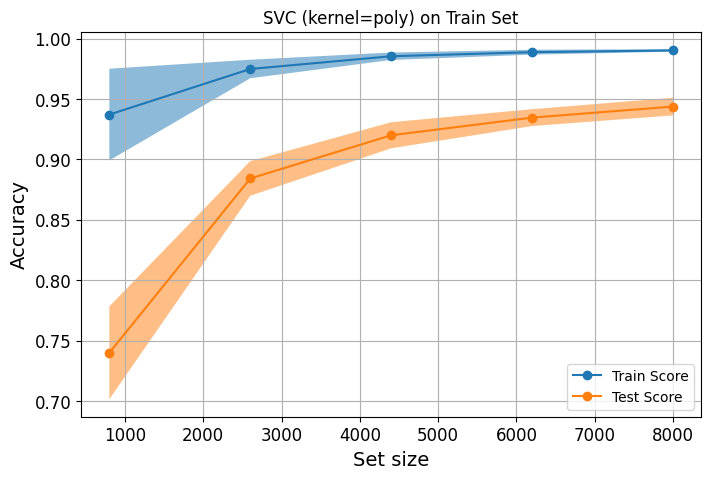

In [87]:
draw_learning_curve(rnd_search_poly.best_estimator_, X_train_scaled[:10000], y_train[:10000], 'SVC (kernel=poly) on Train Set')

In [88]:
print_scores(rnd_search_poly.best_estimator_, X_train_scaled, y_train)

Accuracy:  0.9943166666666666
Precision:  0.9943269453500654
Recall:  0.9943166666666666
F1:  0.9943187774751644


In [89]:
print_scores(rnd_search_poly.best_estimator_, X_test_scaled, y_test)

Accuracy:  0.9747
Precision:  0.9747897302599369
Recall:  0.9747
F1:  0.9747057535140259


In [90]:
utl.save_model(rnd_search_poly, "rnd_search_poly")